# Trabalho prático da disciplina SCC0230 - Inteligência Artificial
### Orientadora: profª Draª Solange Oliveira Rezende

### Arthur Hiratsuka Rezende - 13687108
### Caio
### Gustavo
### João


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st

from datetime import timedelta
from haversine import haversine

import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function

import time
import math

import funcoes_busca as busca
import Experiment

def apply_haversine(data : 'dataframe'):
    df = data.copy()
    from haversine import haversine
    for i in range(len(df) - 1):
        coord_a = (df.pos_X[i], df.pos_Y[i])
        coord_b = (df.pos_X[i + 1], df.pos_Y[i + 1])
        df.loc[[i],['weight']] = haversine(coord_a, coord_b)
        
    return df

In [2]:
# Funções interface usuário

def menu_user():
    input_menu = get_input(df)
    orig_input = df['label_source'].loc[df['source'] == input_menu[0]].iloc[0]
    dest_input = df['label_source'].loc[df['source'] == input_menu[1]].iloc[0] 
    best_path(G_calc, df, orig_input, dest_input)


def get_input(df : 'dataframe') -> list:
    input_user = []
    print('Não utilize acentos/caracteres especiais')
    str_input = ''
    flag = 0
    while flag == 0:
        str_input = input('Insira a estação de origem : ').upper()
        flag = len(df.loc[df['source'] == str_input])
        if (flag == 0):
            print("Estação inválida!")
    input_user.append(str_input)
    
    str_input = ''
    flag = 0
    while flag == 0:
        str_input = input('Insira a estação de destino : ').upper()
        # utilizada busca na coluna 'source' pois ela abrange todos os casos
        # ao contrário da coluna 'target'
        flag = len(df.loc[df['source'] == str_input])
        if (flag == 0):
            print("Estação inválida!")
    input_user.append(str_input)
    return input_user


def get_time(sec):
    td_str = str(timedelta(seconds=sec))
    x = td_str.split(':')
    print('\nDuração aproximada do trajeto', x[0], 'horas', x[1], 'minutos', x[2], 'segundos')

def best_path(graph_data : 'graph', dataframe : 'dataframe', origin : str, destination : str):
    path_nodes = nx.shortest_path(graph_data, origin, destination, weight = "weight")
    path_lenght = nx.shortest_path_length(graph_data, origin, destination, weight = "weight")
    aux_troca = 0
    aux_index = 0
    bkp_index = 0
    
    est0 = path_nodes[0].split('-')
    est1 = path_nodes[1].split('-')

    if(est0[0] == est1[0]):
        aux_troca = -1
        aux_index = 1
        bkp_index = 1
    
    key_list = []
    for i in range(len(path_nodes) - 1):
        key = list(graph_data.get_edge_data(path_nodes[i],path_nodes[i + 1]))
        key_list.append(key[0])

    aux_key = key_list[0]
    aux_flag = 0
     
    print('\n\nItinerário resumido:')    
    print(f"{'Embarque na linha:': <25} {key_list[aux_index]: <20} {'Estação:': <10} {path_nodes[aux_index].split('-')[0] : <25}")
    
    for aux_index in range(len(path_nodes) - 1):
        if (aux_flag == 0) and (aux_key != key_list[aux_index]):
            print(f"{'Baldeação para linha:': <25} {key_list[aux_index]: <20} {'Estação:': <10} {path_nodes[aux_index].split('-')[0] : <25}")
            aux_flag = 1
            
        aux_key = key_list[aux_index]
        aux_flag = 0  
        
    print(f"{'Desembarque na linha:': <25} {key_list[-1]: <20} {'Estação:': <10} {path_nodes[-1].split('-')[0] : <25}")
    
    # 30 segundos por parada (metro)
    # 3 minutos baldeação
    # 40km/h velocidade média metro
    
    eta_seconds = ((path_lenght*3600)/40) + ((len(path_nodes) - 1)*30) + (aux_troca * 180)
    print("DISTANCIA ESTIMADA DO TRAJETO:", path_lenght)
    get_time(int(eta_seconds))
    
    print("\nItinerário descriminado:")
    for bkp_index in range(len(path_nodes) - 1):
        if(path_nodes[bkp_index].split('-')[0] != path_nodes[bkp_index + 1].split('-')[0]):
            print(f"{'Linha:   ' +  key_list[bkp_index]: <30} {'Estação:   ' + path_nodes[bkp_index].split('-')[0] : <40} -> {'Estação:   ' + path_nodes[bkp_index + 1].split('-')[0] : <30} ")
        else:
            print(f"\n{'MUDANÇA DE LINHAS NA ESTAÇÃO:   ' + path_nodes[bkp_index].split('-')[0] : <45} {'Linha de origem: ' +  key_list[bkp_index - 1]: <25} ---> {'Linha destino: ' +  key_list[bkp_index + 1]: <30}")

    key_unique = []
    for key in key_list:
        if key not in key_unique:
            key_unique.append(key)
    
    nodes_list = []
    for node in path_nodes:
        aux_str = node.split('-')[0]
        if aux_str not in nodes_list:
            nodes_list.append(aux_str)
    
    plt.figure(figsize = (30,30))
    for elem in key_unique:
        key = elem.split('-')[-1]
        df_edges_aux = df_dict[key][["source", "target", "weight", "label_edge"]]
        df_edges = df_edges_aux.loc[(df_edges_aux['source'].isin(nodes_list)) & (df_edges_aux['target'].isin(nodes_list))]
        
        df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]

        g_col = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')

        nx.draw_networkx(g_col,
                         pos = position_map,
                         with_labels = True,
                         node_size=500, 
                         node_shape = '8',
                         node_color = colour_dict.get(key), 
                         style = 'dashed',
                         font_size = 20)

In [3]:
# Função heurística - distância entre dois pontos palicando haversine
## Utiliza lat/long e considera curvatura da terra
def heuristica(node_A, node_B, df):
    
    coord_a = (0,0)
    coord_b = (0,0)
    flag = 0

    try:
        ca_X = df.loc[(df['label_source'] == node_A)]['pos_X'].iloc[0]
        ca_Y = df.loc[(df['label_source'] == node_A)]['pos_Y'].iloc[0]
        coord_a = (ca_X, ca_Y)
    except IndexError:
        ca_X, ca_Y = None, None
        flag = 1

    try:
        cb_X = df.loc[(df['label_source'] == node_B)]['pos_X'].iloc[0]
        cb_Y = df.loc[(df['label_source'] == node_B)]['pos_Y'].iloc[0]
        coord_b = (cb_X, cb_Y) 
    except IndexError:
        cb_X, cb_Y = None, None
        flag = -1
        
    if flag == 1 : coord_a = coord_b
    if flag == -1: coord_b = coord_a
    return haversine(coord_a, coord_b)

# Visualização do mapa

In [4]:
# Dicionário de cores para plotagem
colour_dict = {'VERMELHA' : '#FF0F00',
              'VERDE' : '#2EFF00',
              'TURQUESA' : '#00E0FF',
               'SAFIRA' : '#385f8f',
               'RUBI' : '#aa443f',
               'PRATA' : '#c0c0c0',
               'LILAS' : '#c8a2c8',
               'JADE' : '#00A86B',
               'ESMERALDA' : '#50c878',
               'DIAMANTE' : '#b9f2ff',
               'CORAL' : '#ff7f50',
               'AZUL' : '#4169e1',
               'AMARELA' : '#ffff00',
              }

# Variável -> velocidade média do metrô
train_speed = 40

# Tratamento inicial dos dados
## importar e fazer bkp dados
df_raw = pd.read_csv('metroetrem_sp_comlinks.csv')
df_original = df_raw.copy()

## Renomear colunas
df_raw.rename(columns={"estacao_upp": "source", "link": "target", "nome_lin" : "name", "long" : "pos_X", "lat" : "pos_Y"}, inplace = True)

## Criar coluna de peso das arestas
df_raw['weight'] = 0
df_raw = apply_haversine(df_raw)

## Aplicar mapa de cores
df_raw['colour'] = df_raw['name'].map(colour_dict)

## Inserir dados faltantes/Corrigir inconsistências
df_raw.loc[len(df_raw.index)] = [4, 'AMARELA', -46.662161, -23.555044, 'PAULISTA', 'CONSOLACAO', 0.5, '#ffff00']
df_raw.loc[len(df_raw.index)] = [2, 'VERDE', -46.660974, -23.557372, 'CONSOLACAO', 'PAULISTA', 0.5, '##2EFF00']
df_raw.loc[df_raw['source'] == 'PALMEIRAS BARRA FUNDA', 'source'] = 'BARRA FUNDA'

## Criar labels para os nós
### Colunas 'Labels' são utilizadas no cálculo do trajeto
### Colunas 'source & target' são utilizadas na plotagem do trajeto
df_raw['num_lin'] = df_raw['num_lin'].astype('str')
df_raw['label_edge'] = df_raw['num_lin'] + '-' + df_raw['name']
df_raw['label_source'] = df_raw['source'] + '-' + df_raw['num_lin']
df_raw['label_target'] = df_raw['target'] + '-' + df_raw['num_lin']

# df_raw

In [5]:
# Manipulação dos dados para plotagem de cada linha separadamente

## Copiar dados e remover valores nulos/Nan
df_map = df_raw.copy()
df_map.dropna(inplace = True)
df_map.drop(df_map.loc[df_map['weight'] == 0].index, inplace = True)

## Criar dict de posição dos nodes
aux_pos = df_map[["source", "pos_X", "pos_Y"]].copy()
aux_pos.drop_duplicates(subset = ['source'], keep = 'first', inplace = True)
position_map = aux_pos.set_index('source').T.to_dict('list')

## Remover estações duplicadas
df_map.drop(df_map.loc[df_map['source'] == df_map['target']].index, inplace = True)
df_map_bkp = df_map.copy()

## Criar dicionário que cada chave contenha os dados das estações de dada linha
## -> linha : dataframe da linha
linhas_id = df_map.name.unique()
df_dict = {elem : pd.DataFrame() for elem in linhas_id}

## Laço para plotar cada linha
for key in df_dict.keys():
    df_dict[key] = df_map[:][df_map.name == key]
    
    
## Laço para plotar
# for key in df_dict:
#     plt.figure(figsize = (20,5))
#     title = 'Linha ' + df_map['num_lin'].loc[df_map['name'] == key].iloc[0] + '-' + key.capitalize()
#     plt.title(title)
#     df_edges = df_dict[key][["source", "target", "weight"]]
#     df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]
# 
#     g_key = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')
# 
#     nx.draw_networkx(g_key,
#                      pos = position_map,
#                      with_labels = True,
#                      node_size=75, 
#                      node_shape = '8',
#                      node_color = colour_dict.get(key), 
#                      style = 'dashed',
#                      font_size = 7)

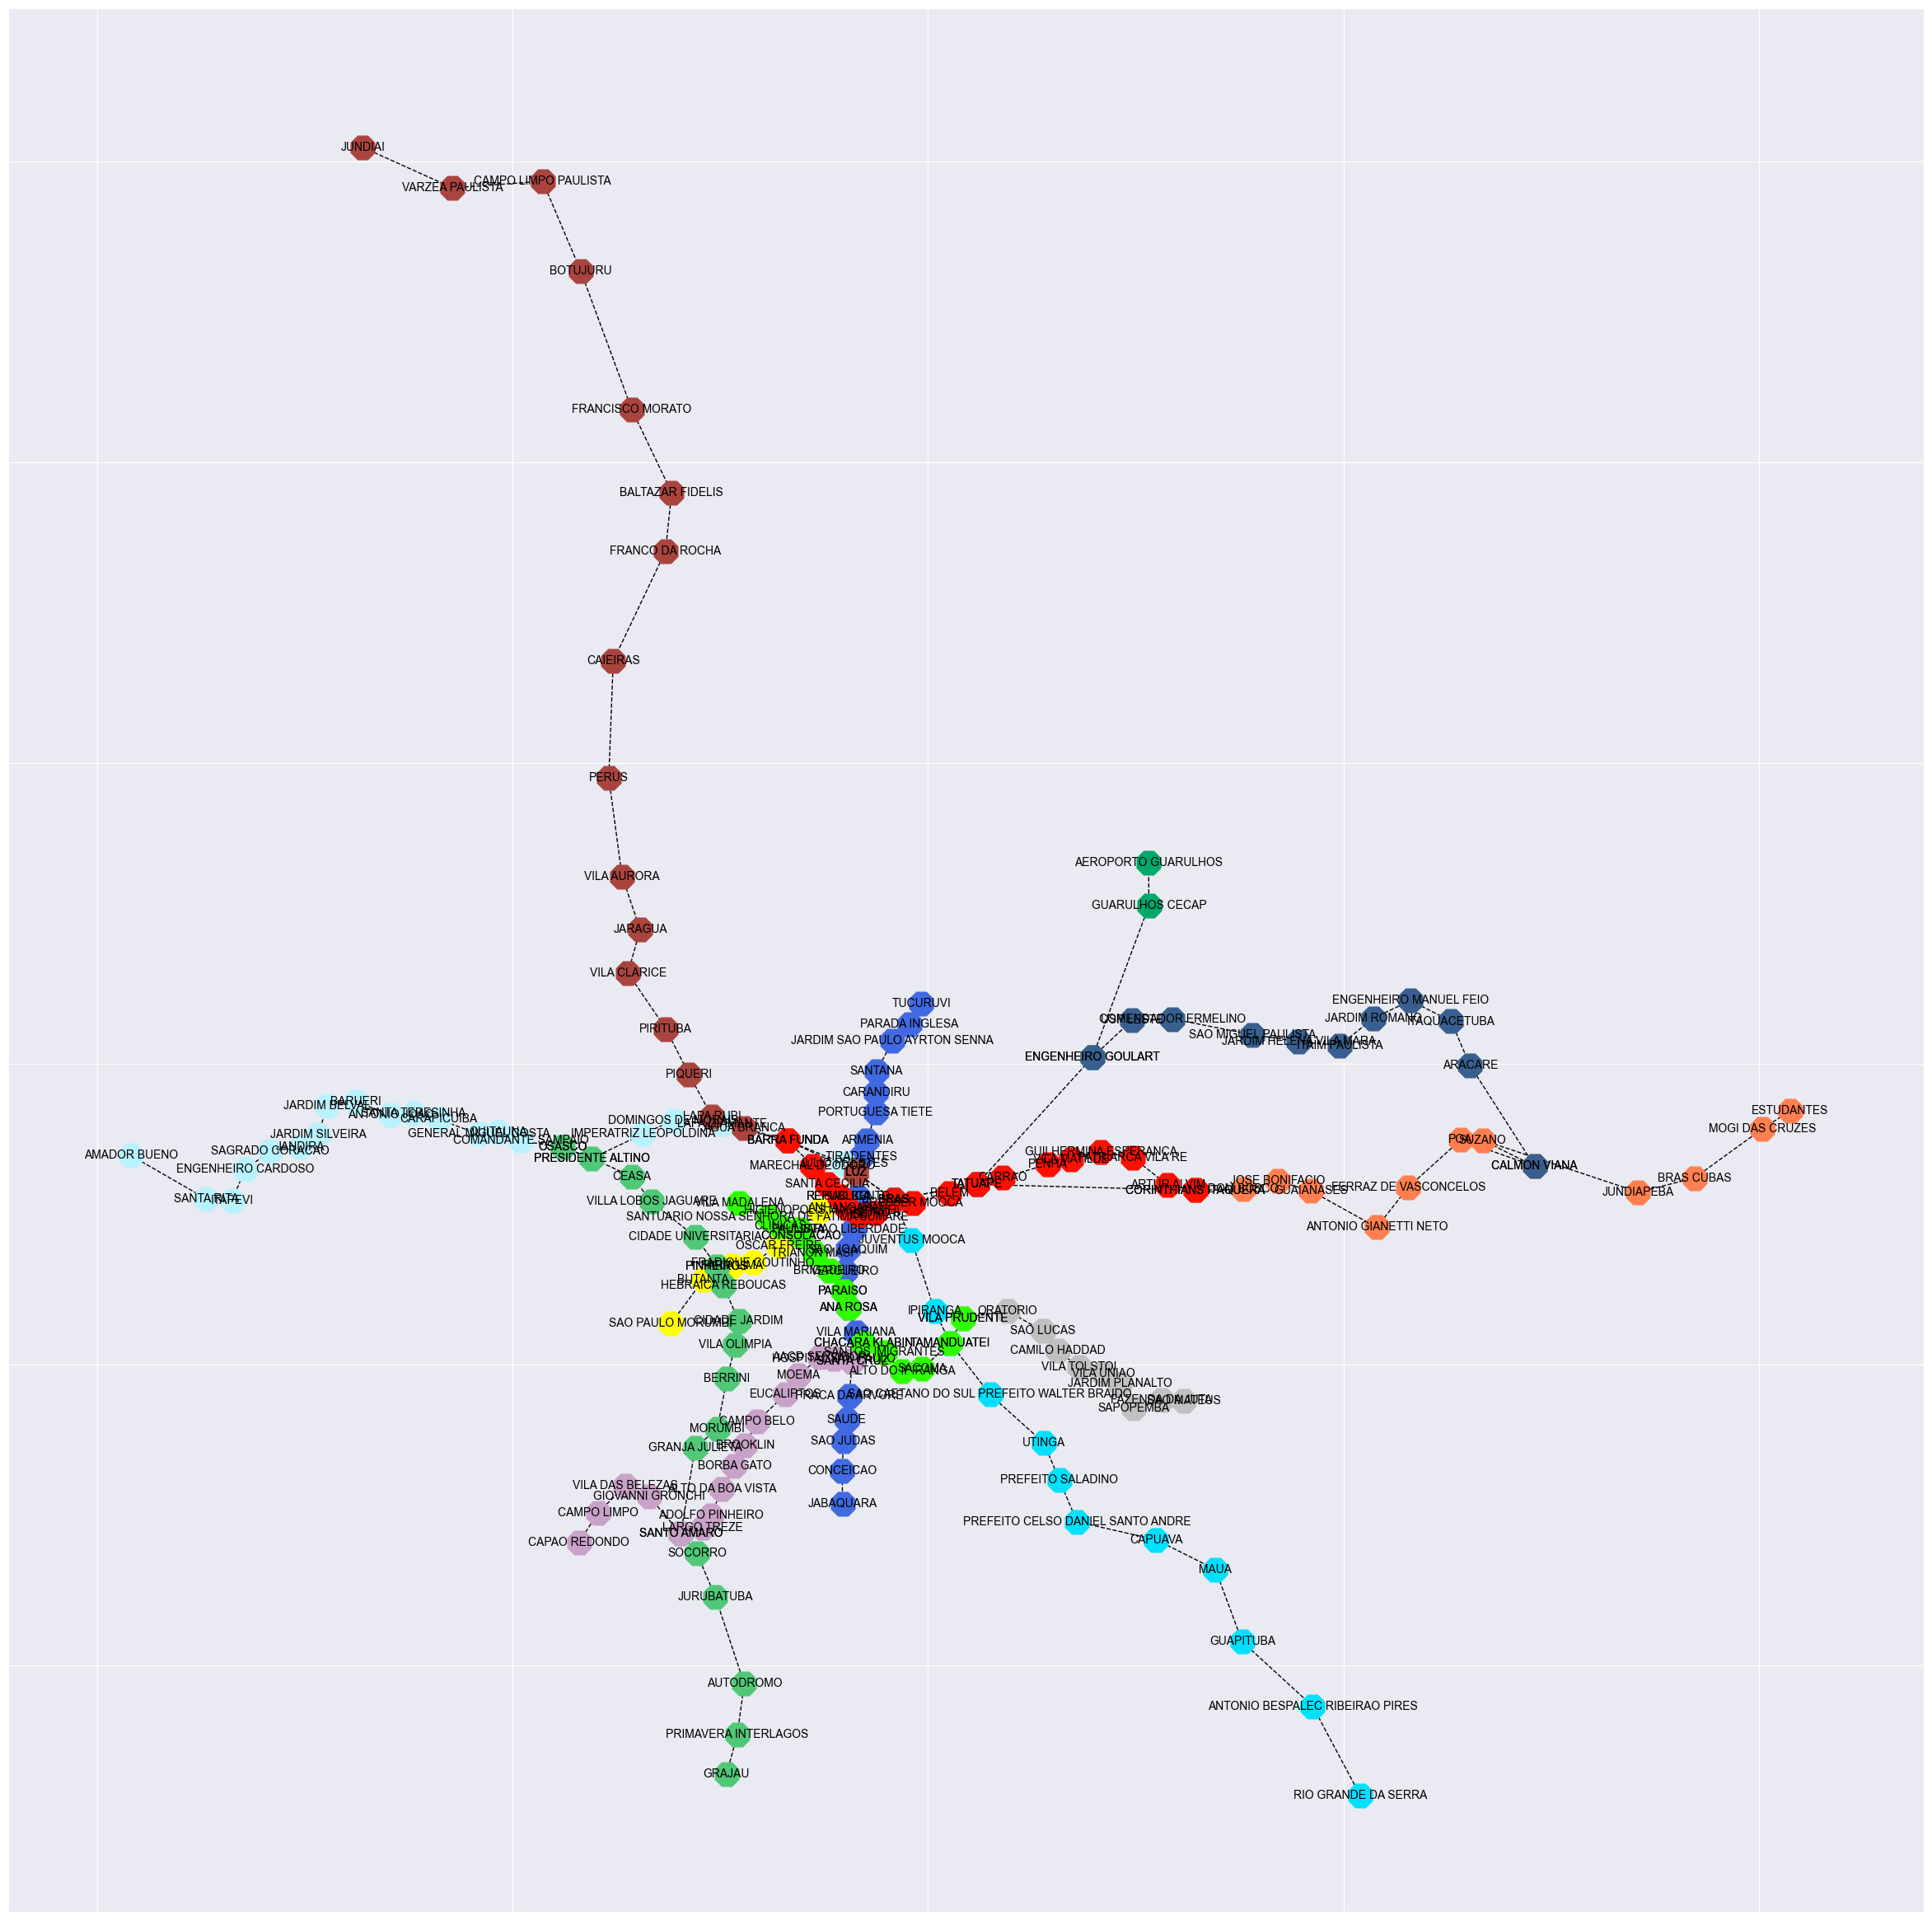

In [6]:
# Manipulação dos dados para plotagem de malha inteira

plt.figure(figsize = (30,30))
for key in df_dict:
    df_edges = df_dict[key][["source", "target", "weight"]]
    df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]

    g_full = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')
    nx.draw_networkx(g_full,
                     pos = position_map,
                     with_labels = True,
                     node_size=500, 
                     node_shape = '8',
                     node_color = colour_dict.get(key), 
                     style = 'dashed',
                     font_size = 10)
    
plt.savefig("malha_full.png")

# Manipulação dos dados para os cálculos de melhor trajeto

In [7]:
## Adicionar estações que fazem conexão com mais de uma linha (baldeação)

## Criar dataframe que recebe estações que tem baldeação
columns_list = df_raw.columns.values.tolist()
df_baldea = pd.DataFrame(columns = columns_list)

## Copiar as estações que são 'source'/origem de mais de um trajeto
df_aux = df_raw[df_raw.duplicated('source')].sort_values('source')
bald_list = df_aux['source'].unique()

## Preencher o dataframe com conexões entre a mesma estação mas entre diferentes linhas (e.g. Luz-Azul -> Luz-Coral)
for elem in bald_list:
    slice_bald = df_raw.loc[df_raw['source'] == elem]   
    for i in range(len(slice_bald)):
        for j in range(i + 1, len(slice_bald)):
            df_baldea.loc[len(df_baldea.index)] = [slice_bald.iloc[i][0],
                                                   slice_bald.iloc[i][1],
                                                   slice_bald.iloc[i][2],
                                                   slice_bald.iloc[i][3],
                                                   slice_bald.iloc[i][4],
                                                   slice_bald.iloc[i][4],
                                                   (train_speed/12),
                                                   slice_bald.iloc[i][7],
                                                   slice_bald.iloc[i][8],
                                                   slice_bald.iloc[i][9],
                                                   slice_bald.iloc[j][9]]

            
## Concatenar o dataframe original com o que contem as baldeações
# display(df_baldea)
df = pd.concat([df_raw, df_baldea]).sort_values('num_lin').reset_index(drop= True)
df = df.reindex(index = df.index[::-1])

df.dropna(inplace = True)
df.drop(df.loc[df['weight'] == 0].index, inplace = True)


## Criar um dict de posição dos nodes (source e target)
aux_pos_source = df[["label_source", "pos_X", "pos_Y"]].copy()
aux_pos_target = df[["label_target", "pos_X", "pos_Y"]].copy()

aux_pos_source = aux_pos_source.drop_duplicates()
aux_pos_target = aux_pos_target.drop_duplicates()

position_source = aux_pos_source.set_index('label_source').T.to_dict('list')
position_target = aux_pos_target.set_index('label_target').T.to_dict('list')

position = position_source.copy()
position.update(position_target)

## Criar o grafo utilizado para cálculo de trajeto
G_calc = nx.from_pandas_edgelist(df, source = 'label_source', target = 'label_target', edge_attr = 'weight', create_using = nx.MultiGraph, edge_key = 'label_edge')

C:\Users\arthu\AppData\Local\Temp\ipykernel_16896\1662994895.py:46: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  position_target = aux_pos_target.set_index('label_target').T.to_dict('list')


In [8]:
caminho = busca.a_estrela(G_calc, 'SUZANO-11', 'LUZ-7', df)
caminho

['SUZANO-11',
 'CALMON VIANA-11',
 'POA-11',
 'FERRAZ DE VASCONCELOS-11',
 'ANTONIO GIANETTI NETO-11',
 'GUAIANASES-11',
 'JOSE BONIFACIO-11',
 'DOM BOSCO-11',
 'CORINTHIANS ITAQUERA-11',
 'TATUAPE-11',
 'BRAS-11',
 'BRAS-7',
 'LUZ-7']

In [9]:
busca.a_estrela_distancia(G_calc, 'SUZANO-11', 'LUZ-7', df)

43.48202184318695

In [10]:
teste = Experiment.NewExperiment(Graph= G_calc, Dataframe = df)
teste.run_experiment(n_exp=2500, n_rep=5)

df_obs = teste.df_result
df_obs.describe()

Tempo total do experimento: 2868.4226763248444s


,len_AStar,dist_AStar,time_AStar,len_dfs,dist_dfs,time_dfs,len_djk,dist_djk,time_djk,len_hrt,...,delta_dist,delta_timeHeur,delta_lenHeur,delta_distHeur,delta_timeInfo,delta_lenInfo,delta_distInfo,delta_timeNao,delta_lenNao,delta_distNao
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.0,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,15.973200,27.838489,0.065289,28.382800,55.814644,0.000535,15.973200,27.838489,0.000448,15.973200,...,-27.976154,-0.057413,0.0,0.0,0.025315,-1.820800,-3.380316,0.000087,12.409600,27.976154
std,7.749303,17.140830,0.042715,15.900736,31.415972,0.000421,7.749303,17.140830,0.000303,7.749303,...,27.344446,0.043772,0.0,0.0,0.029111,4.185845,5.694355,0.000476,13.867154,27.344446
min,1.000000,0.000000,0.000003,1.000000,0.000000,0.000002,1.000000,0.000000,0.000001,1.000000,...,-119.633626,-0.379374,0.0,0.0,-0.108637,-21.000000,-40.676353,-0.006306,-8.000000,0.000000
25%,10.000000,14.721252,0.032433,15.000000,31.614709,0.000163,10.000000,14.721252,0.000222,10.000000,...,-45.580901,-0.082117,0.0,0.0,0.004204,-3.000000,-4.228868,-0.000217,0.000000,3.464036
50%,16.000000,25.334780,0.056716,26.000000,51.782239,0.000449,16.000000,25.334780,0.000435,16.000000,...,-19.048770,-0.048688,0.0,0.0,0.017367,0.000000,-0.072687,-0.000016,9.000000,19.048770
75%,21.000000,37.662636,0.093288,40.000000,79.731403,0.000842,21.000000,37.662636,0.000661,21.000000,...,-3.464036,-0.024484,0.0,0.0,0.040752,0.000000,0.000000,0.000417,20.000000,45.580901
max,42.000000,99.597413,0.382362,70.000000,135.515405,0.002498,42.000000,99.597413,0.007161,42.000000,...,0.000000,0.053489,0.0,0.0,0.231302,11.000000,1.000000,0.002358,58.000000,119.633626


In [11]:
len(df_obs.loc[df_obs['delta_dist']==0])/len(df_obs), df_obs["time_AStar"].max()/df_obs["time_dfs"].max()

(0.1556, 153.05490353040426)

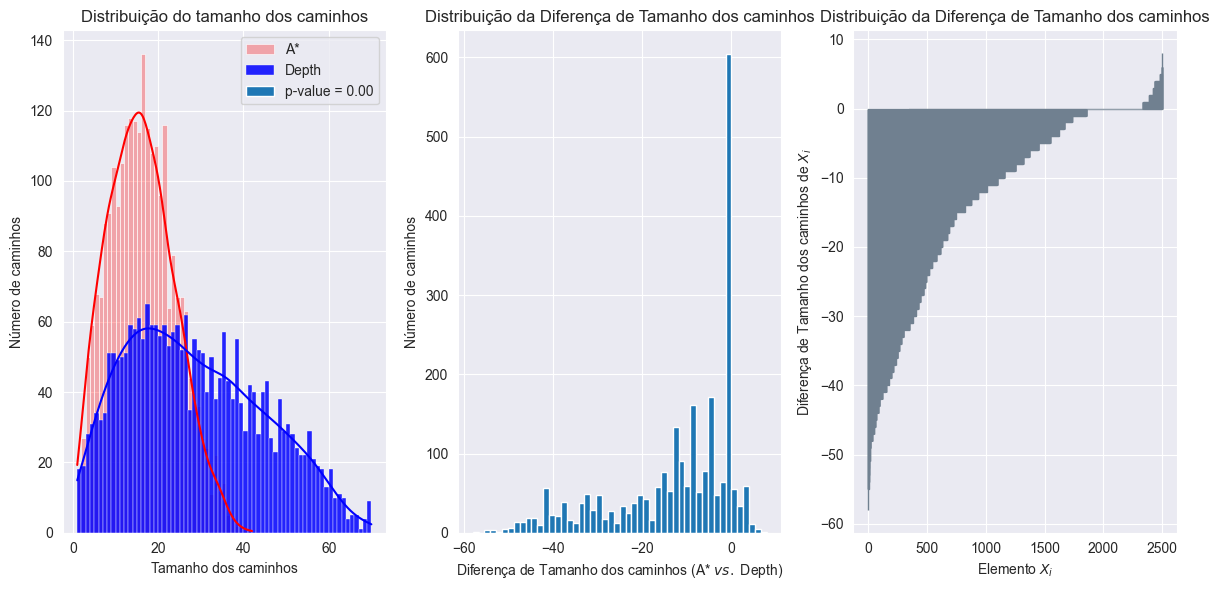

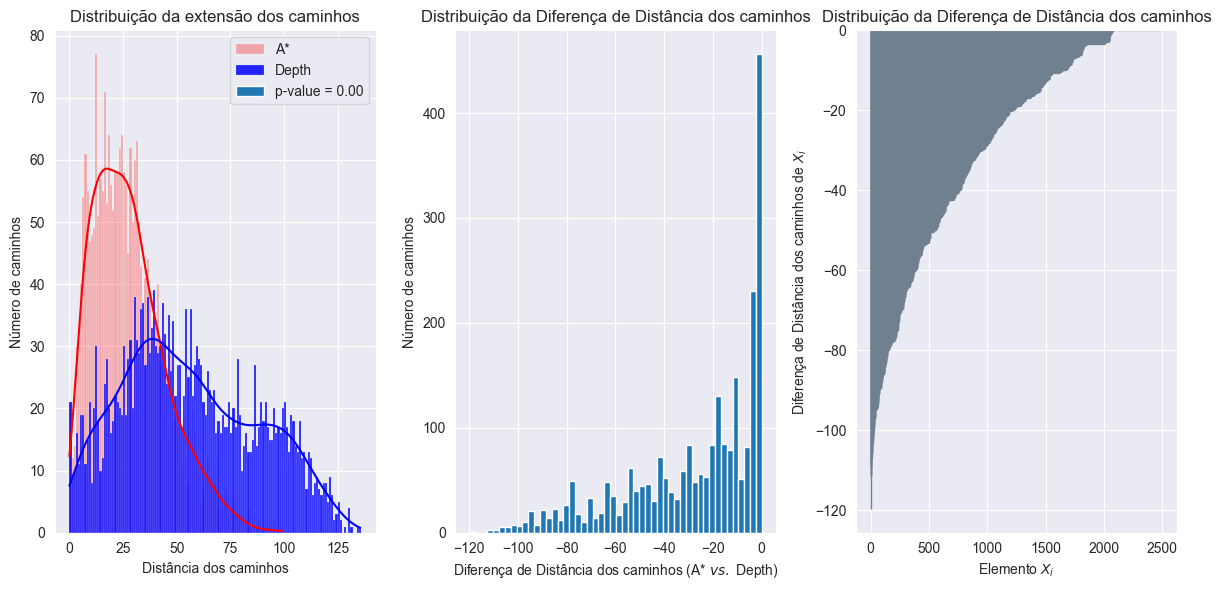

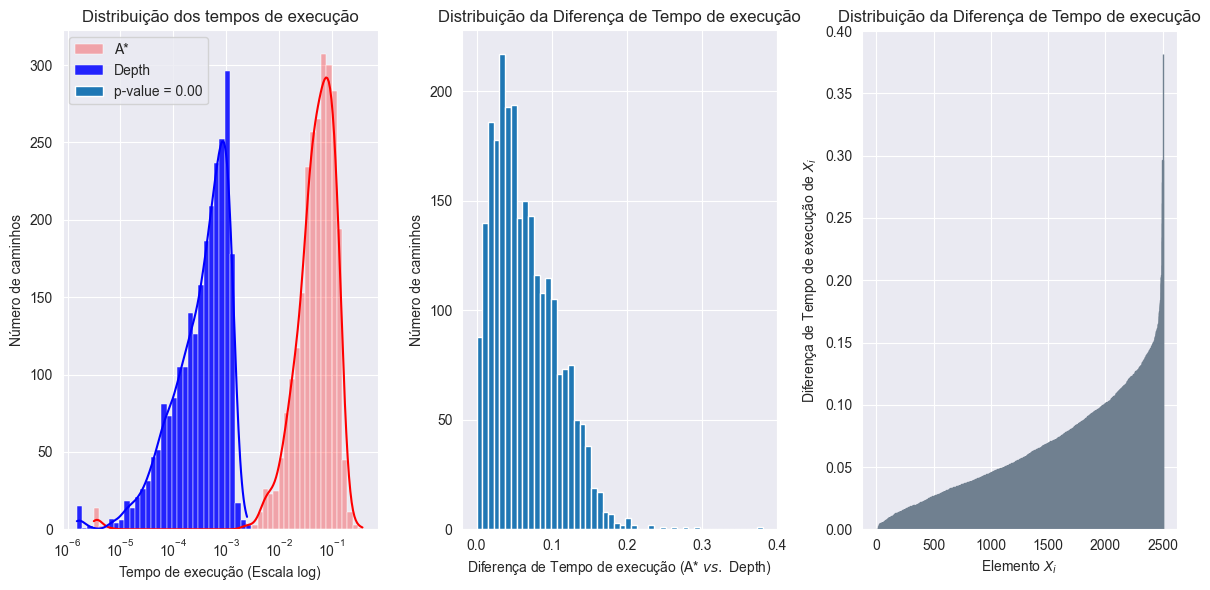

In [12]:
lista_prefixo = ["len_", "dist_", "time_"]
lista_sufixo = ["AStar", "dfs"]

for idx, prefixo in enumerate(lista_prefixo): 
    Experiment.plot_distrib(df_obs, prefixo+lista_sufixo[0], prefixo+lista_sufixo[1], idx)

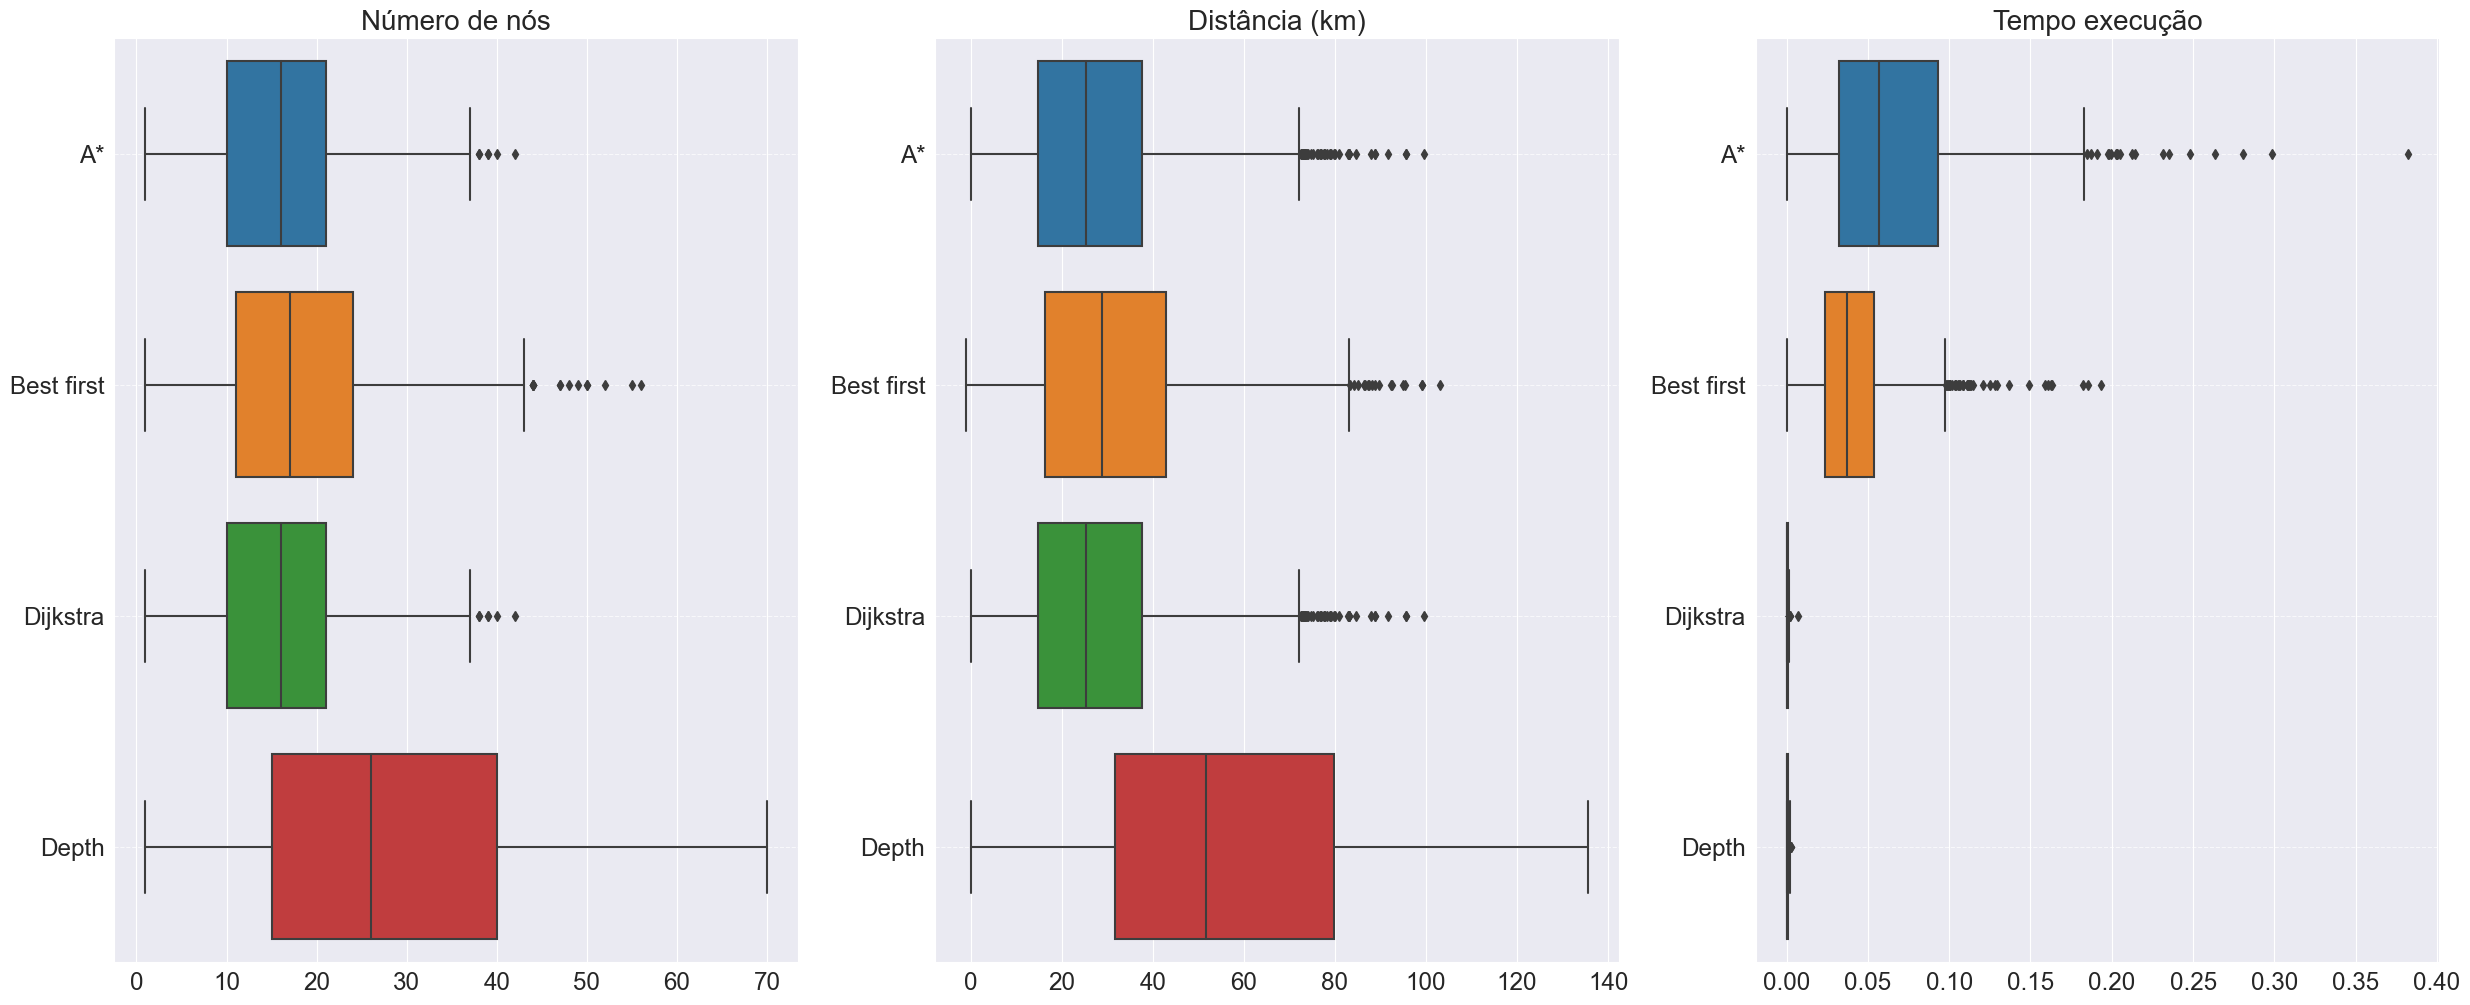

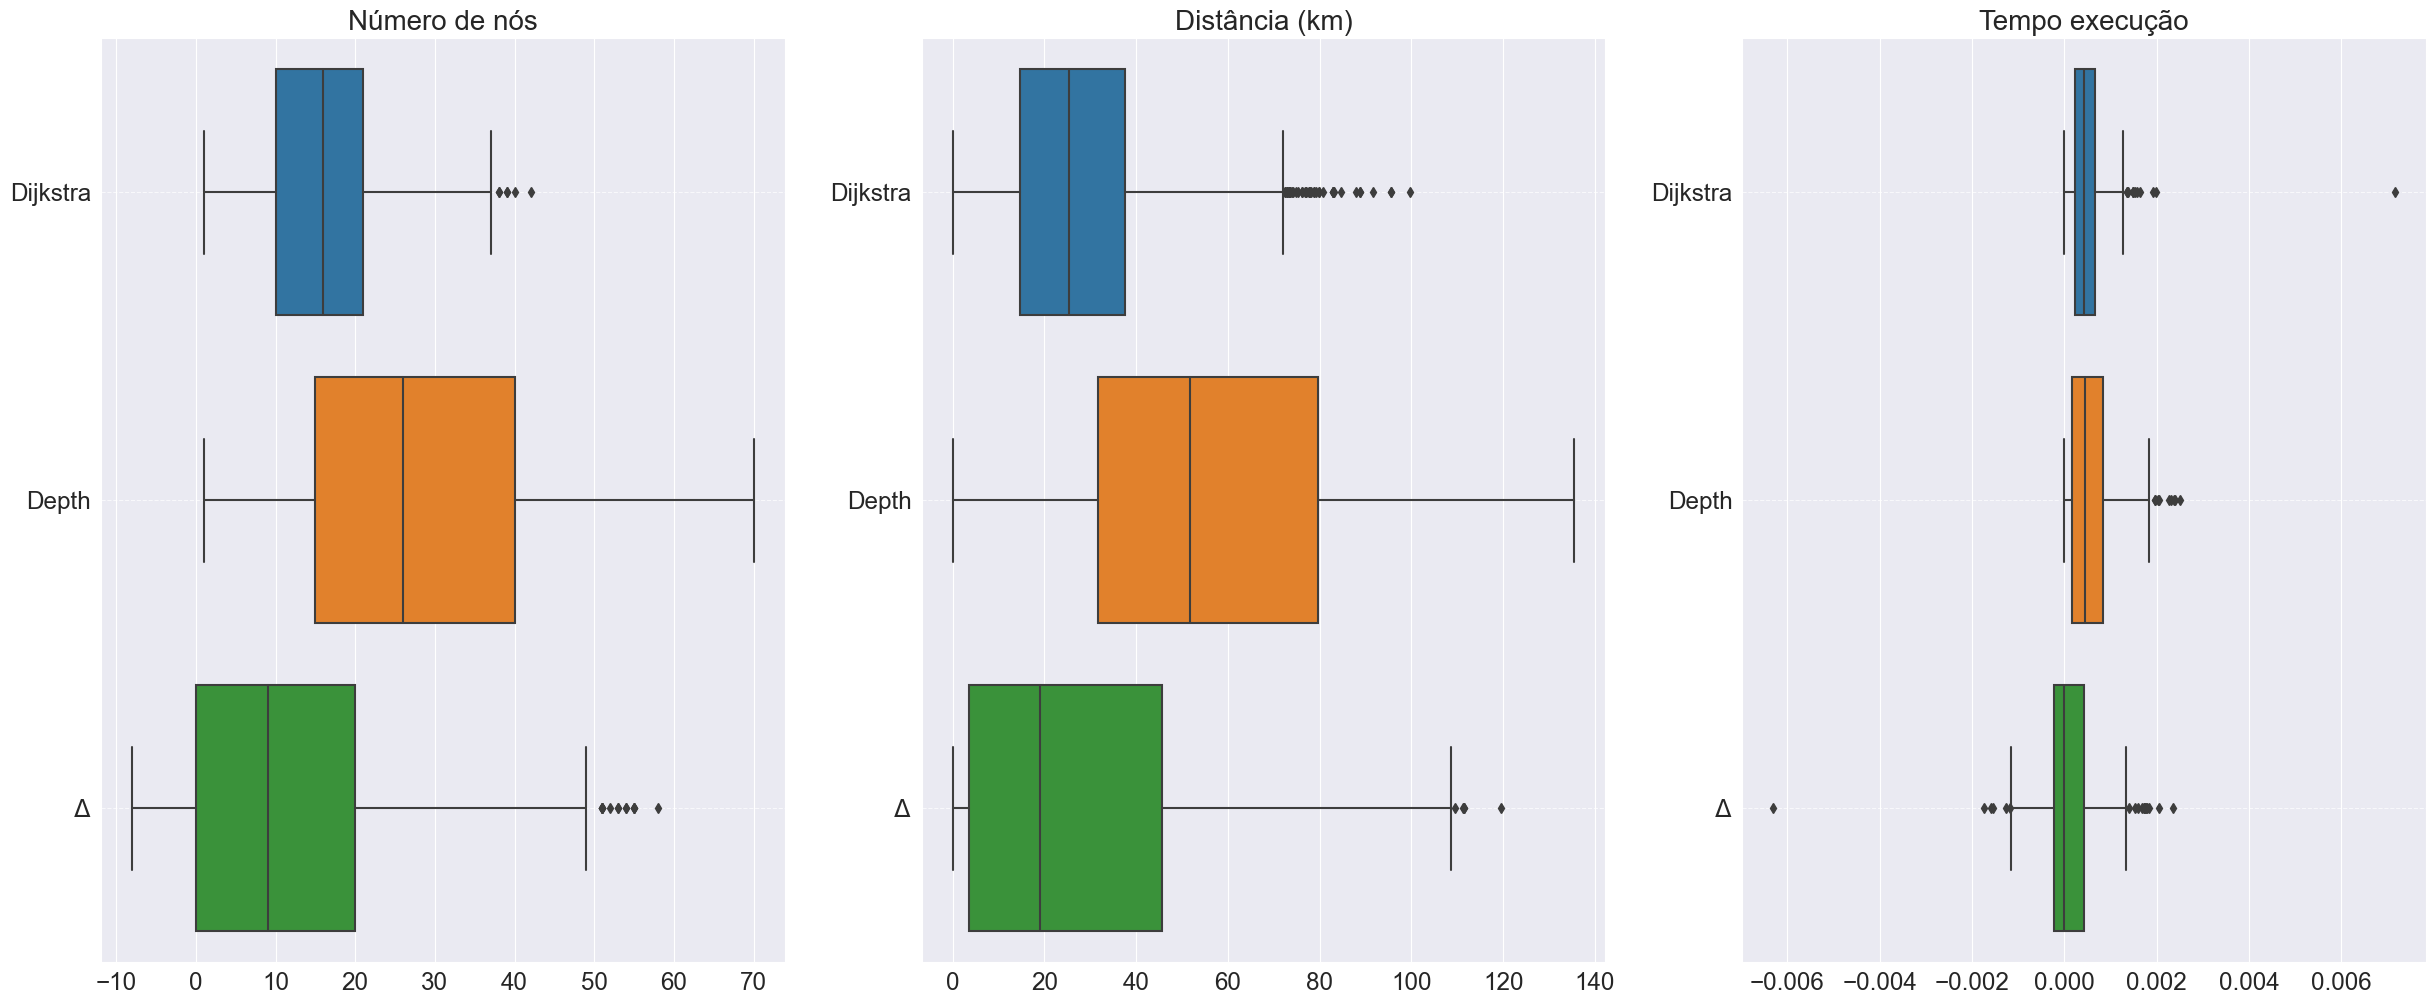

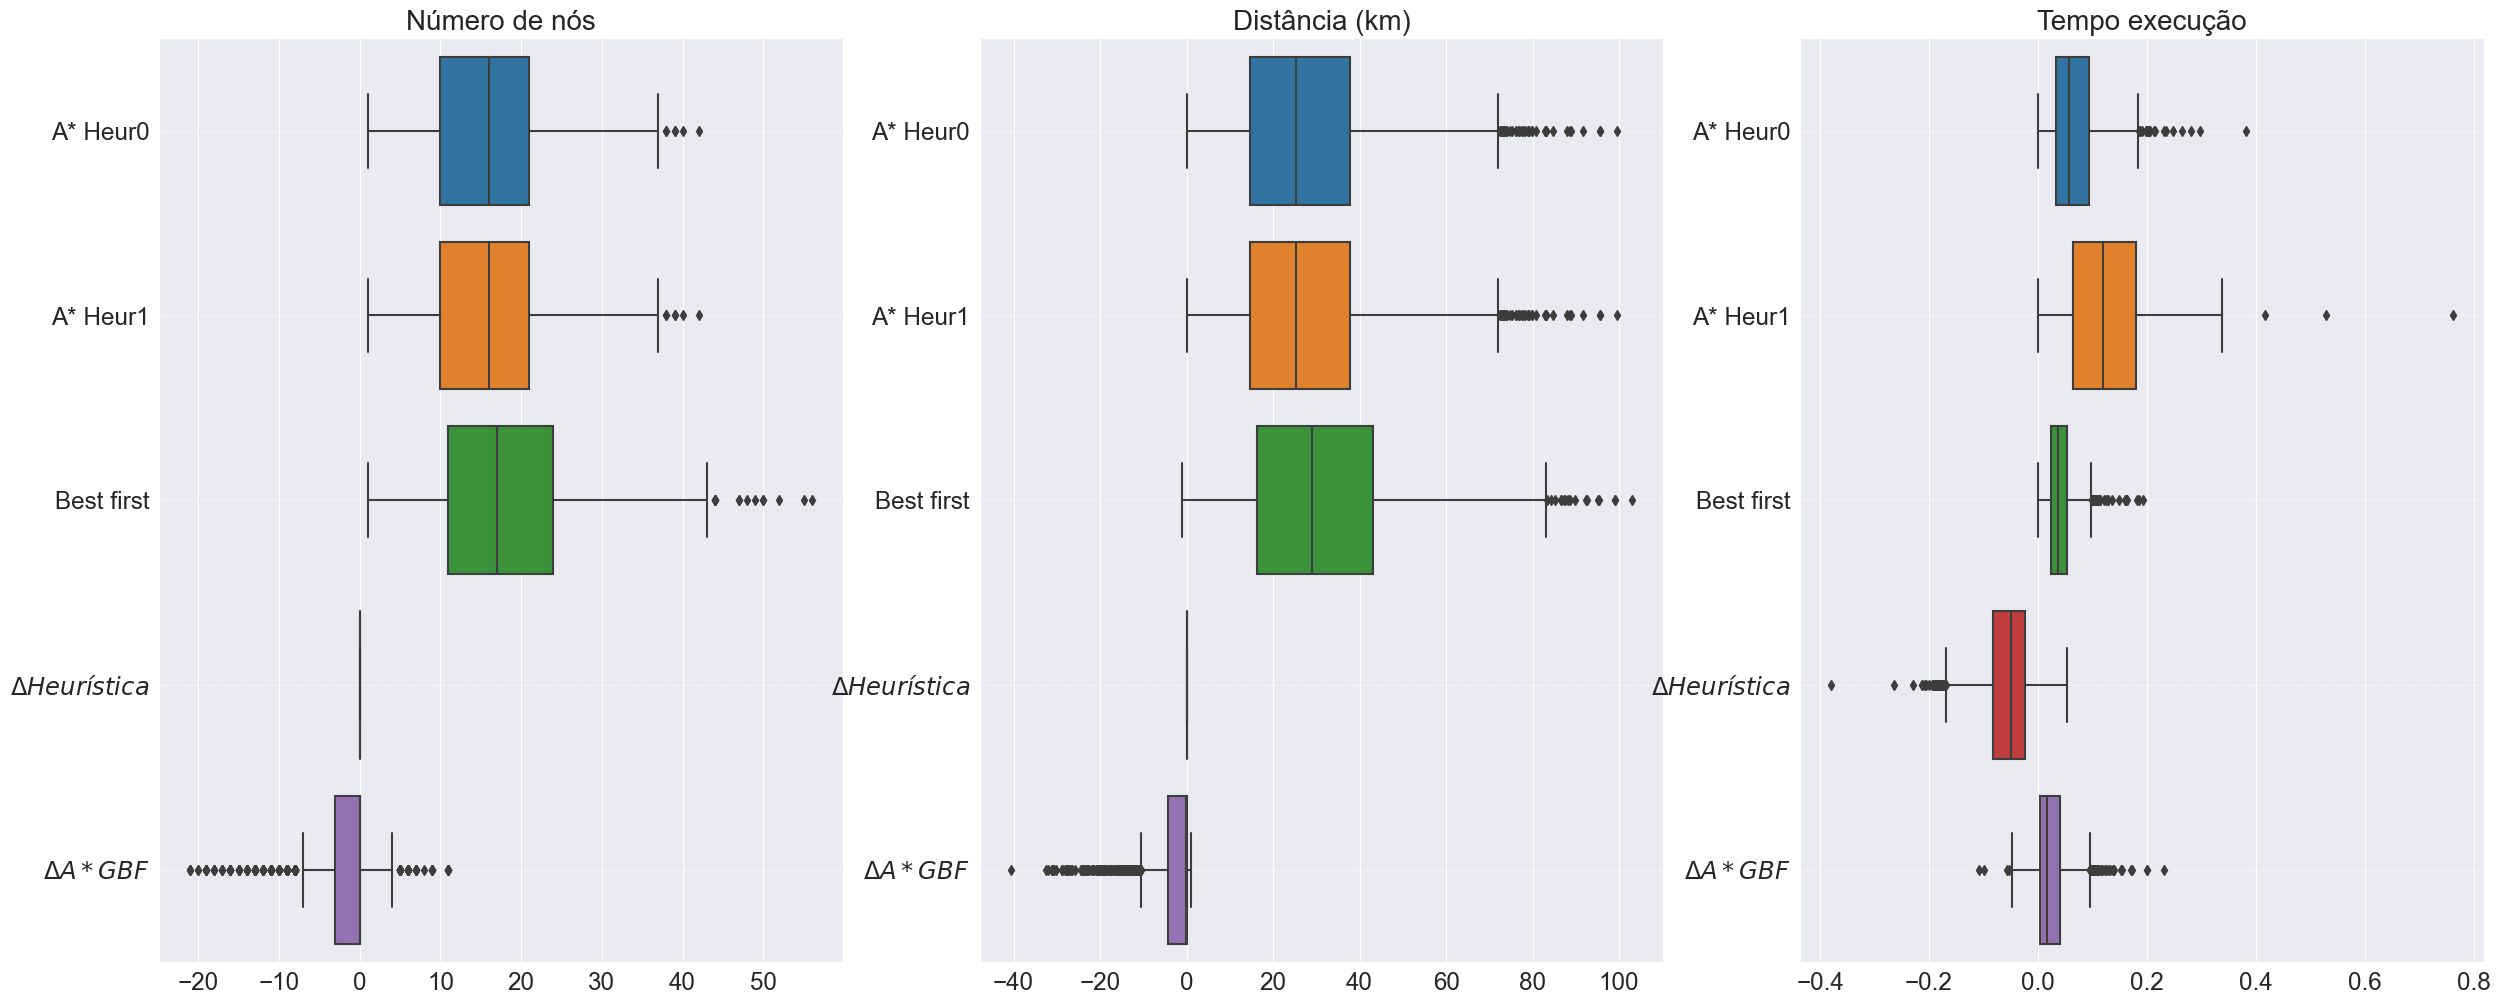

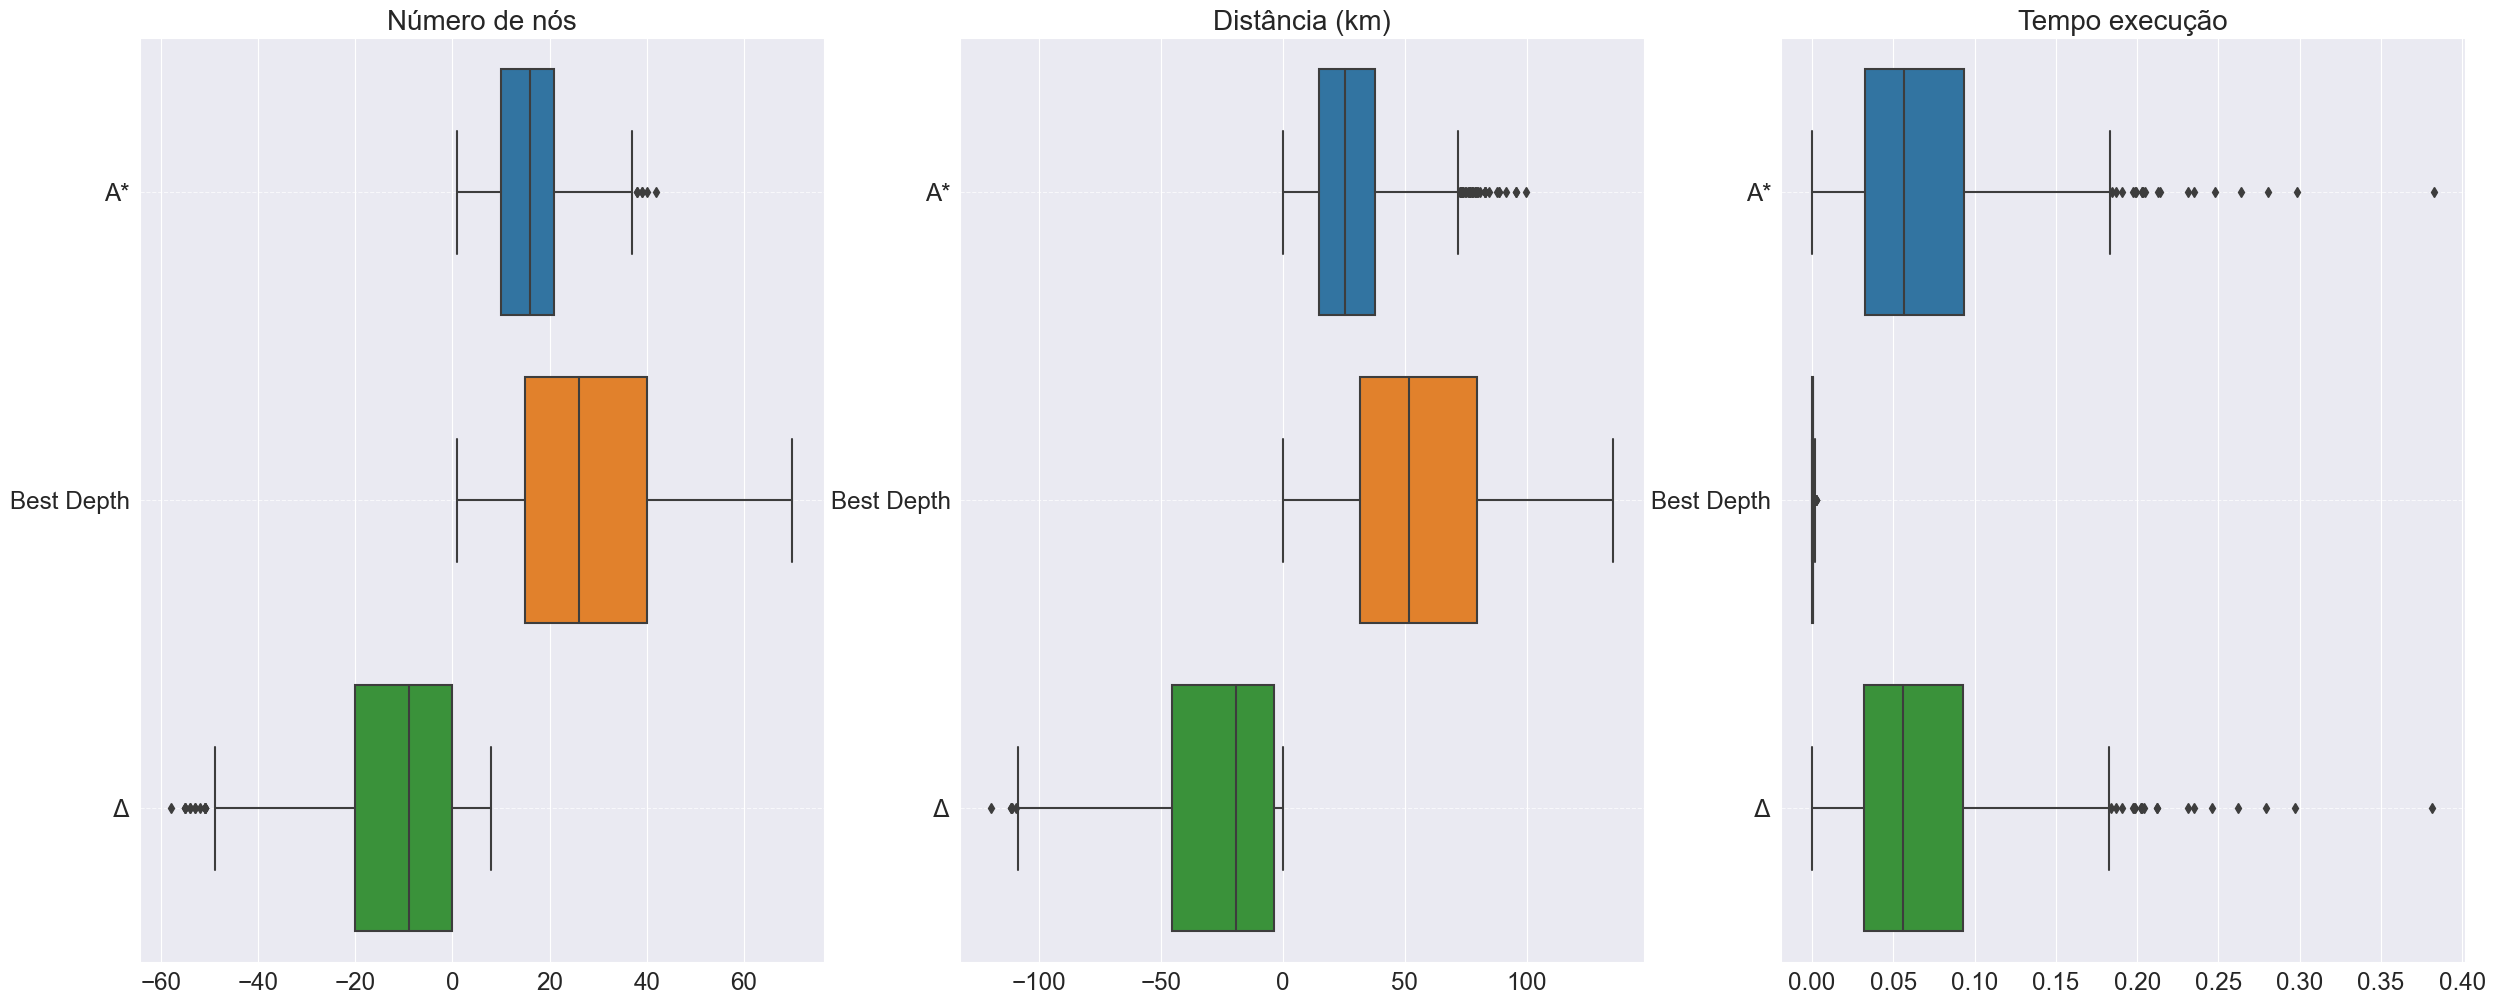

In [13]:
Experiment.plot_boxplots(df_obs)